In [105]:
import os
import gc
import argparse
import time
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from dgl import DGLGraph
from dgl.data import register_data_args, load_data
from dgl.nn.pytorch.conv import SAGEConv

import pickle as pkl
import pandas as pd
import numpy as np

from dataclasses import dataclass, field, asdict, make_dataclass
from typing import List, Callable
from collections import defaultdict
from itertools import product

from importlib import reload

import utils
import graph_model
import graph_utils
reload(utils)
reload(graph_model)
reload(graph_utils)

from utils import get_metrics_dict
from graph_utils import build_graph, get_train_val_test_masks
from graph_model import GraphSAGE

from sklearn.preprocessing import MultiLabelBinarizer

In [106]:
PATH_TO_DATA = "/scratch/mz2476/wiki/data/aligned_datasets/"
PATH_TO_MODELS = "models/"

device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

In [12]:
# Load data
#load feature dataframes
with open(os.path.join(PATH_TO_DATA, "graph_df.pkl"), "rb") as f:
    wiki_graph_df = pkl.load(f)

with open(os.path.join(PATH_TO_DATA, "text_embed_en.pkl"), "rb") as f:
    wiki_feature_df = pkl.load(f)

with open(os.path.join(PATH_TO_DATA, "en_outlinks_tokens_df.pkl"), "rb") as f:
    wiki_label_df = pkl.load(f)
    
joined_df = wiki_feature_df.join(wiki_graph_df, lsuffix='1')
joined_df = joined_df.join(wiki_label_df, lsuffix='2').sort_values(by='node_id')

In [100]:
%%time
G = build_graph(joined_df, directed=True)

CPU times: user 16.4 s, sys: 841 ms, total: 17.2 s
Wall time: 17.6 s


In [101]:
# Labels
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(joined_df.mid_level_categories)
labels = torch.FloatTensor(labels)

# Add train/val/test masks
train_mask, val_mask, test_mask = get_train_val_test_masks(G.number_of_nodes())

# Add features for all nodes
G.ndata['node_id'] = torch.arange(G.number_of_nodes())
embeds = np.nan_to_num(np.stack(joined_df.text_1000_embed.values), nan=0.)
G.ndata['_text_embed'] = torch.FloatTensor(embeds)

# Add features ONLY for train
G.ndata['_topics'] = labels * train_mask[:, None].float()
G.ndata['_empty'] = torch.zeros(G.number_of_nodes(), 0)

In [102]:
from functools import partial

@dataclass(frozen=True)
class Args:
    embedding_dim    : int = 150
    n_hidden         : int = 150
    n_layers         : int = 2
    aggregator_type  : str = "mean" # ``mean``, ``gcn``, ``pool``, ``lstm``
    activation       : Callable = partial(F.leaky_relu, negative_slope=0.1)

    n_classes    : int = labels.shape[1]
    num_nodes    : int = G.number_of_nodes()
    features_dim : int = 0

    lr           : float = 0.01
    weight_decay : float = 0.
    dropout      : float = 0.1
    step_size    : int = 200
    n_epochs     : int = 100
        
args = Args()

In [103]:
from graph_utils import predict, train_GraphSAGE, get_gpu_memory_map

In [107]:
G.ndata["features"] = G.ndata['_empty']

# ['_empty'] 100 150 1 gcn
args = Args(
            features_dim=G.ndata["features"].shape[1],
            embedding_dim=100,
            n_hidden=150,
            n_layers=1,
            aggregator_type="gcn",
            lr=0.01,
            n_epochs=120,
        )

model = GraphSAGE(**asdict(args))

model.to(device)
labels = labels.to(device)
G.ndata["features"] = G.ndata["features"].to(device)
G.ndata["node_id"] = G.ndata["node_id"].to(device)
train_mask = train_mask.to(device)
val_mask = val_mask.to(device)

use_loss_reweighting = False
pos_weights = 1 / labels[train_mask].mean(axis=0) if use_loss_reweighting else None
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights)
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model_parameters, lr=args.lr, weight_decay=args.weight_decay)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=0.01)

model, metrics = train_GraphSAGE(model, criterion, optimizer, exp_lr_scheduler, 
                device, "test", asdict(args), args.n_epochs,
                G, labels, train_mask, val_mask, return_model=True)

/scratch/mz2476/miniconda3/envs/graph/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch 99 | Train Loss: 0.06474 | Validation f1_micro 0.624

Training complete in 0m 26s
Best val f1_micro: 0.6370 



In [109]:
node_embeds = model.get_hidden(G).cpu().detach().numpy()

In [110]:
node_embeds.shape

(33823, 150)

In [111]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

In [112]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(node_embeds)

In [154]:
def plot_components(components, labels, label_id=0, classes=mlb.classes_):
    plt.figure(figsize=(10,6))
    plt.scatter(components[:, 0], components[:, 1], c=labels[:, label_id], s=10, cmap='Wistia') # 'BuGn'
    plt.grid()
    plt.title(classes[label_id])
    plt.show()

In [137]:
mlb.classes_[10]

'Culture.Music'

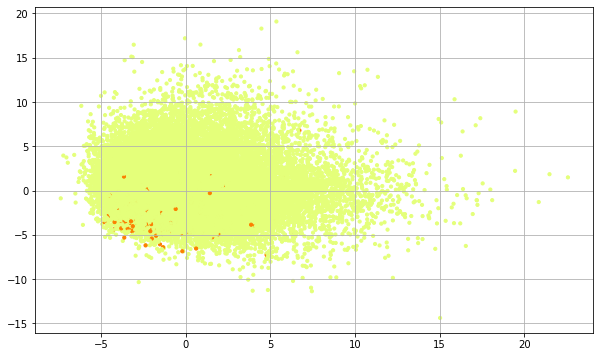

In [138]:
plot_components(pca_components, labels.cpu().detach().numpy(), label_id=10)

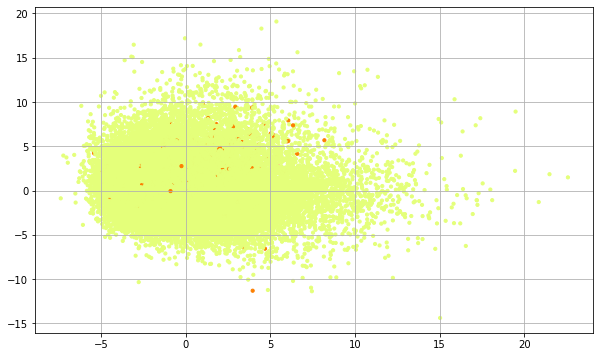

In [132]:
plot_components(pca_components, labels.cpu().detach().numpy(), label_id=-1)

In [148]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [149]:
%%time
# tsne = TSNE(n_components=2, perplexity=20, # 30, 
#             learning_rate=200.0, n_iter=250, metric='euclidean', 
#             random_state=57)


tsne = TSNE(n_jobs=4, perplexity=20,
           learning_rate=200.0, n_iter=250, metric='euclidean', 
            random_state=57)

tsne_components = tsne.fit_transform(node_embeds)

CPU times: user 5min 24s, sys: 2min 58s, total: 8min 23s
Wall time: 4min 12s


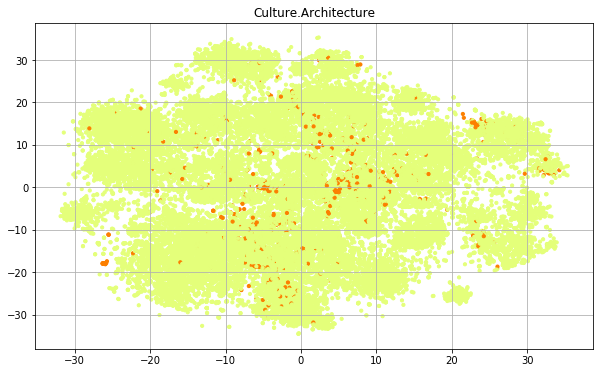

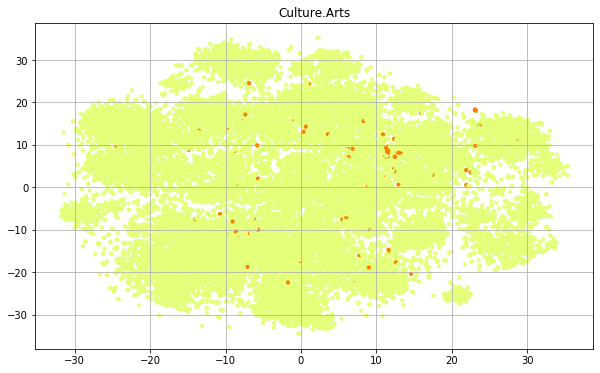

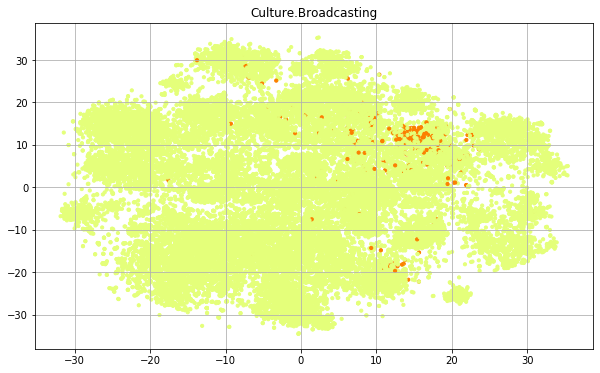

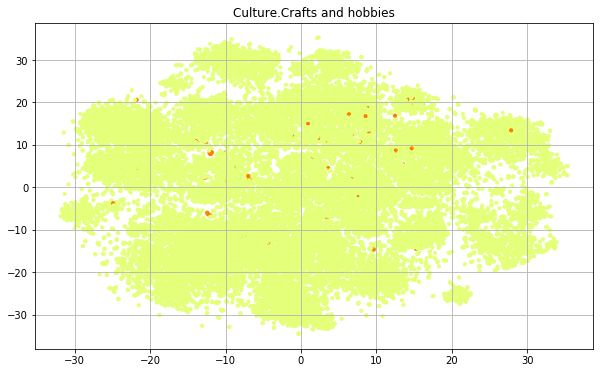

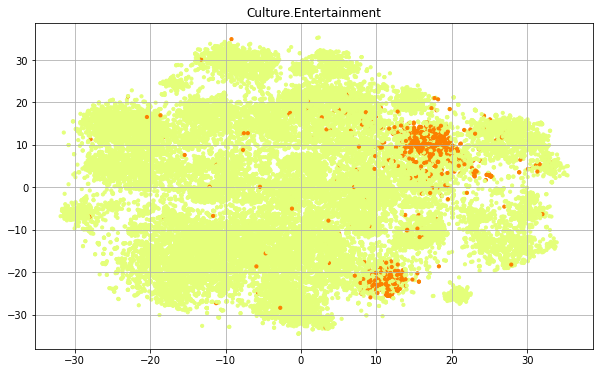

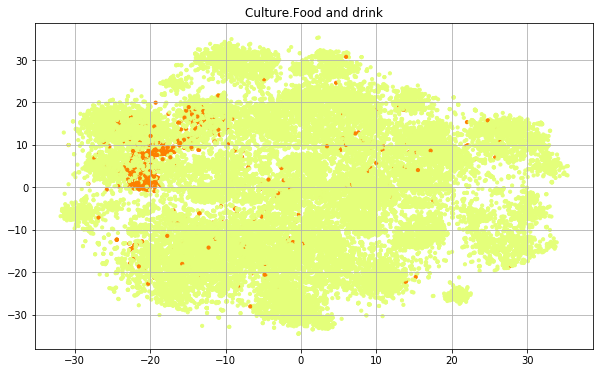

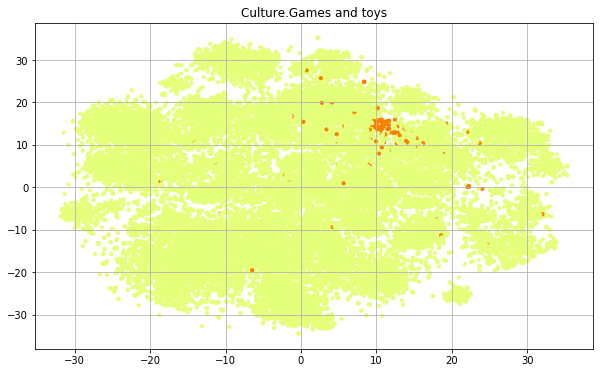

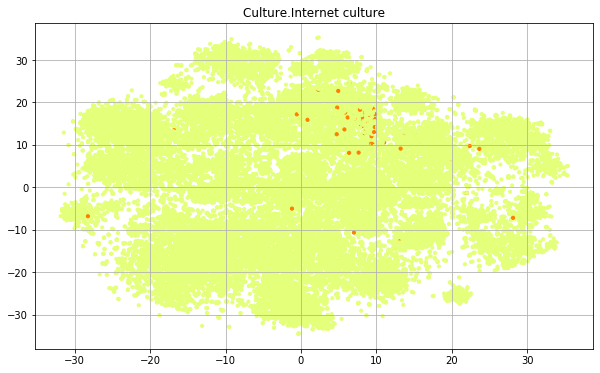

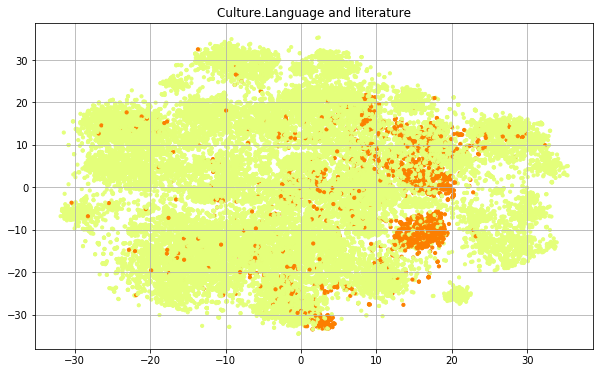

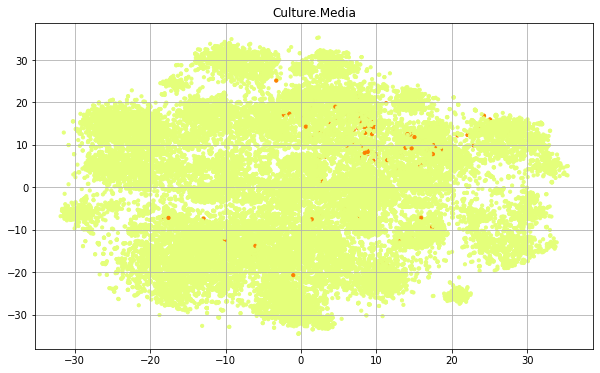

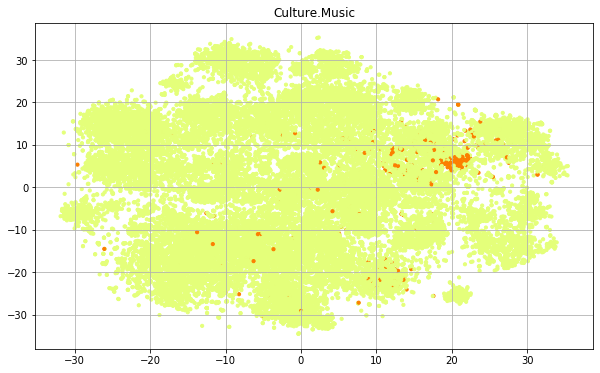

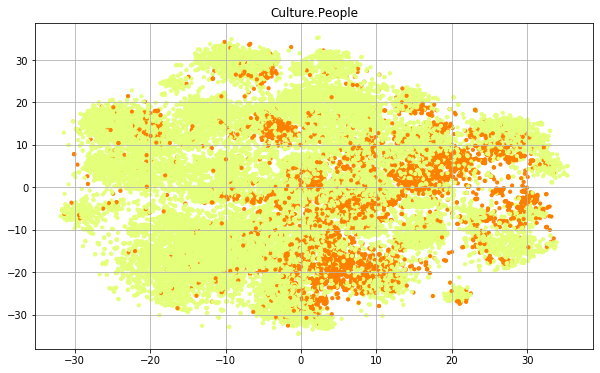

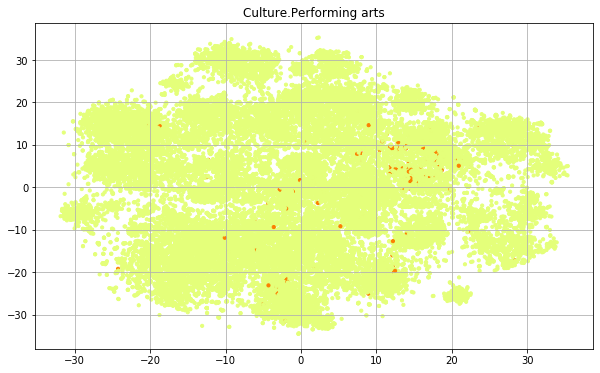

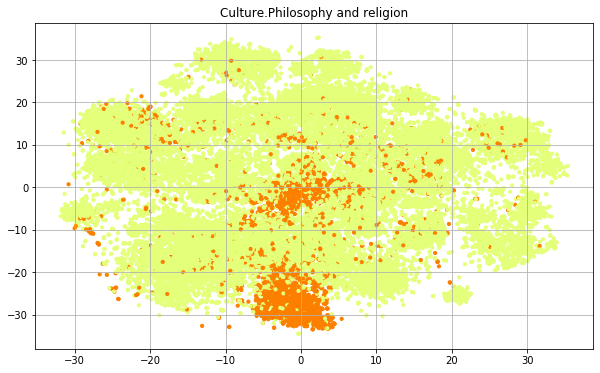

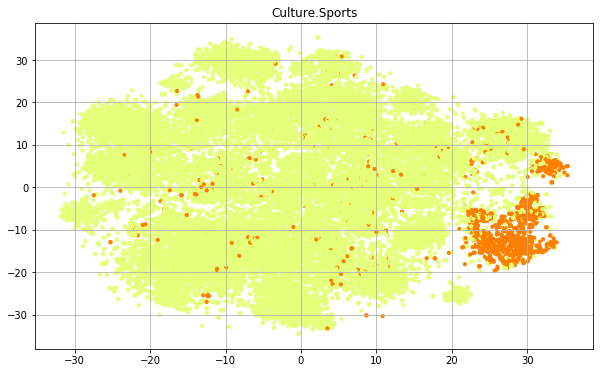

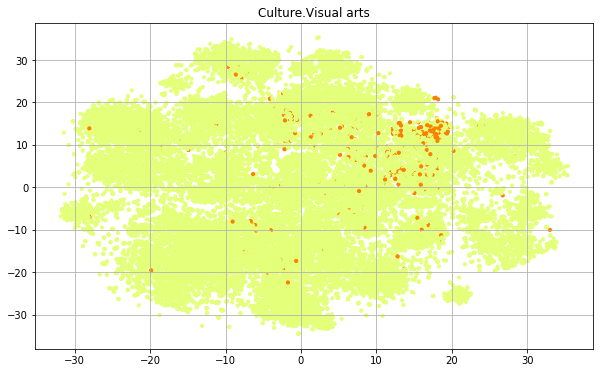

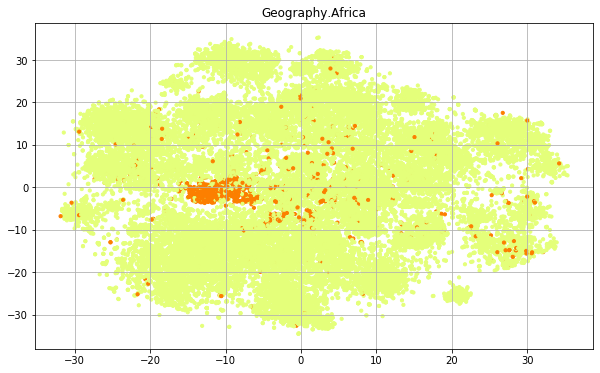

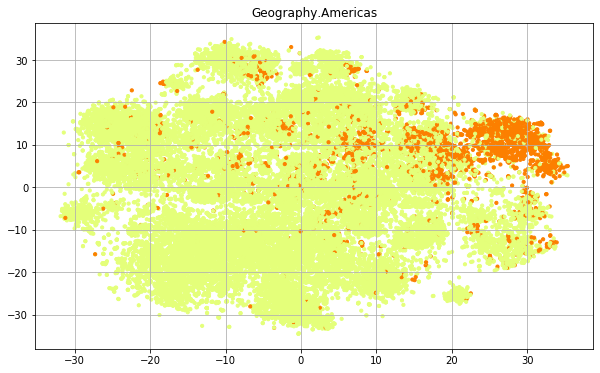

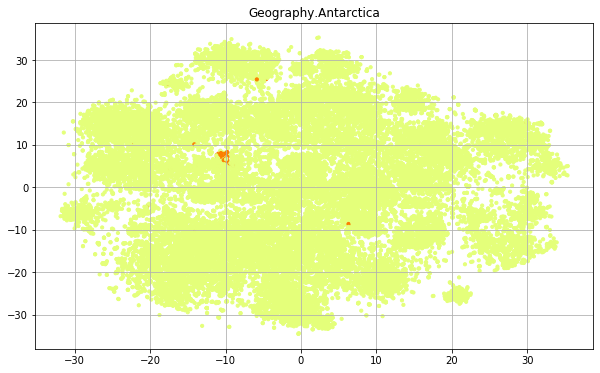

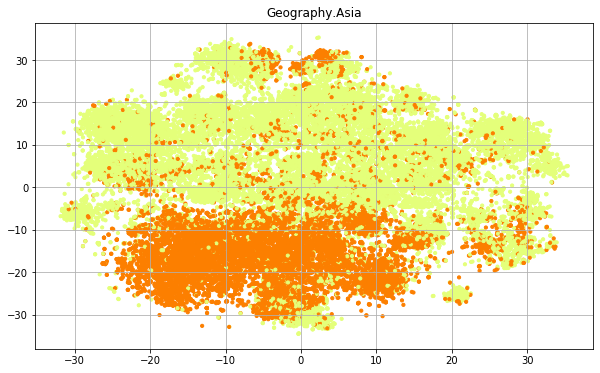

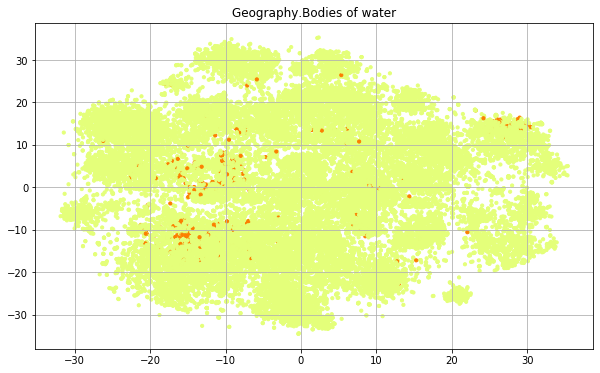

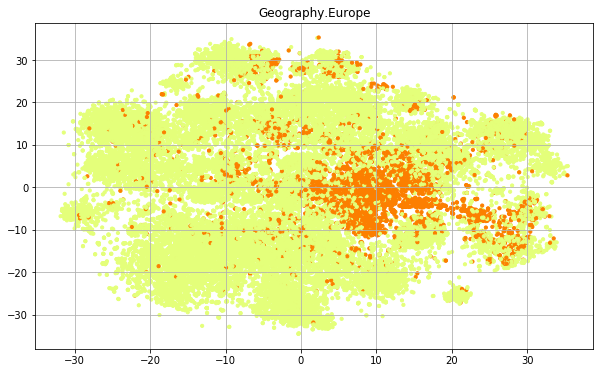

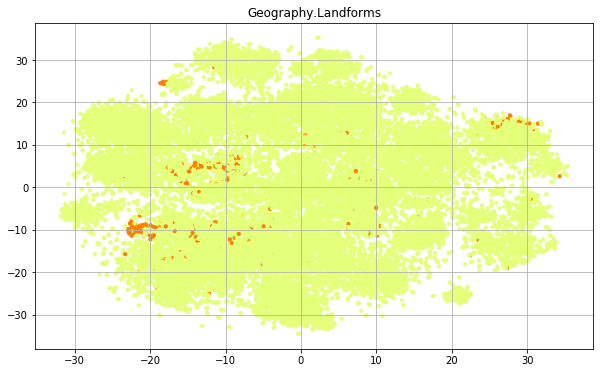

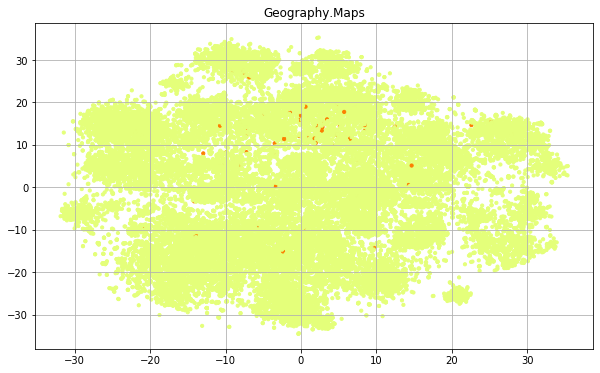

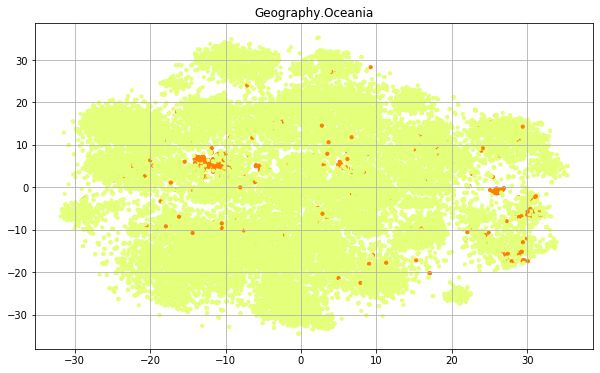

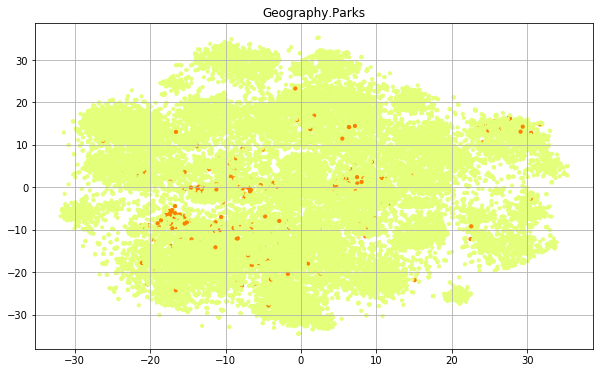

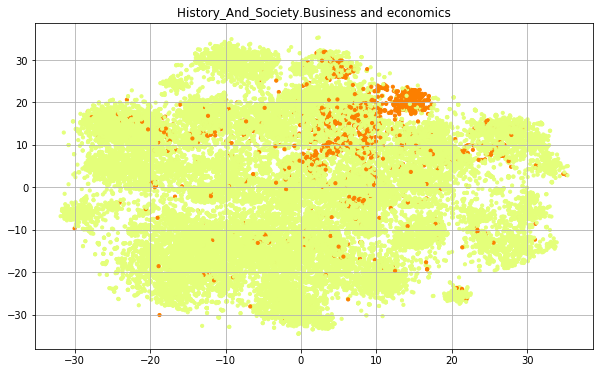

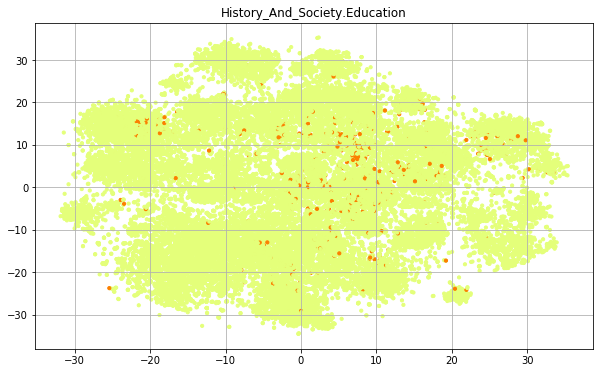

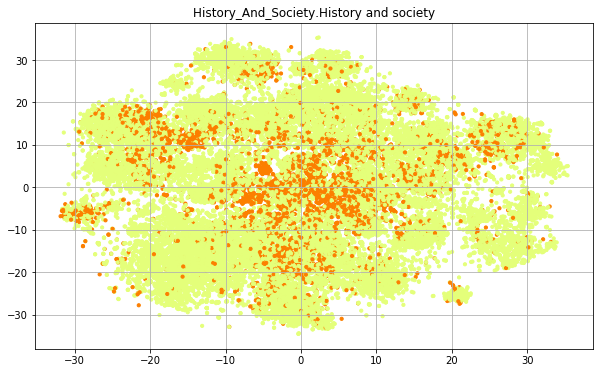

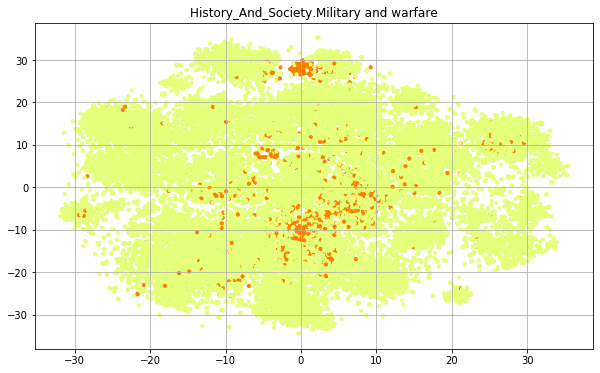

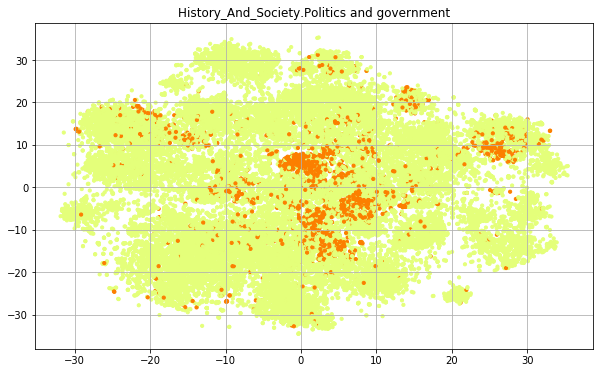

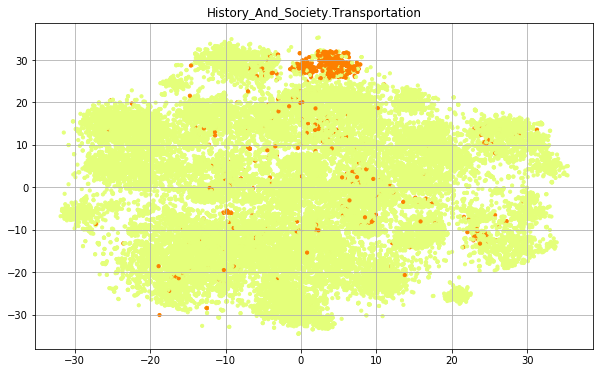

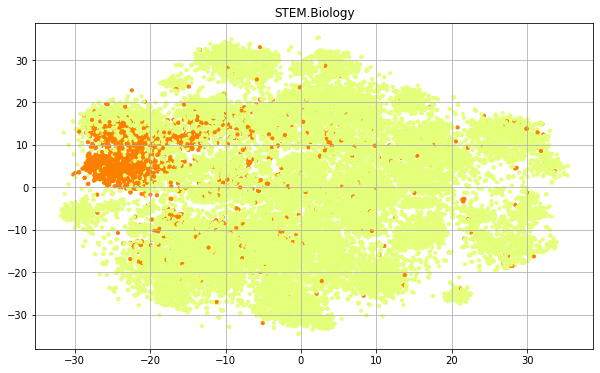

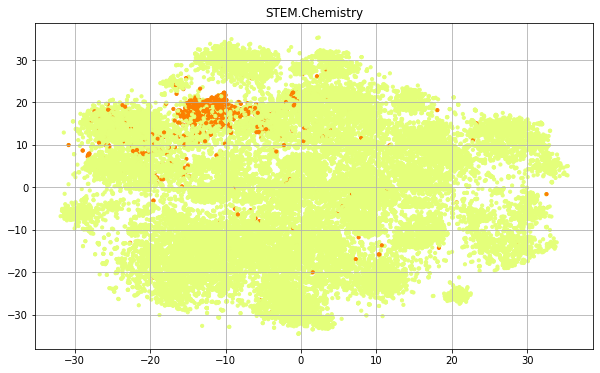

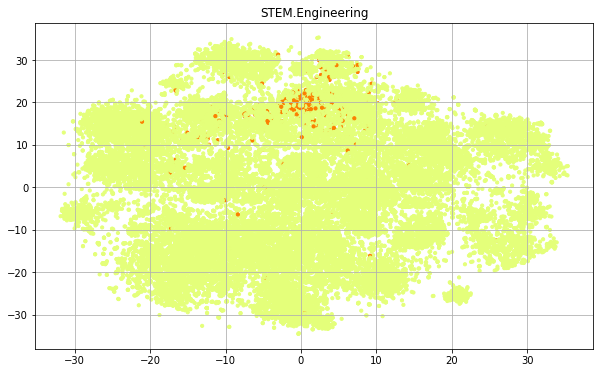

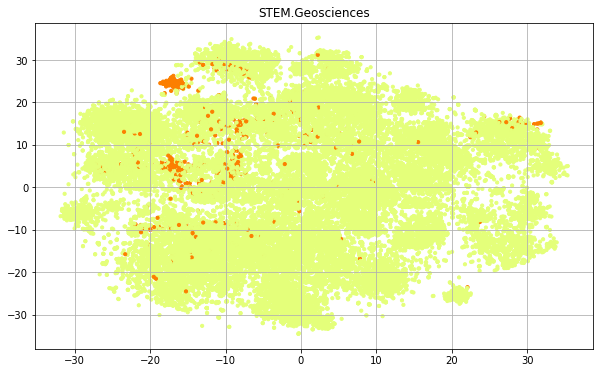

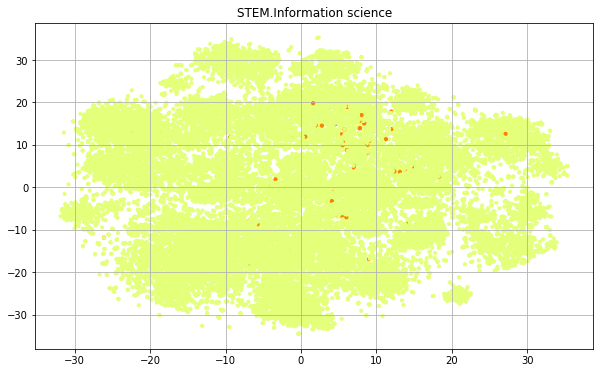

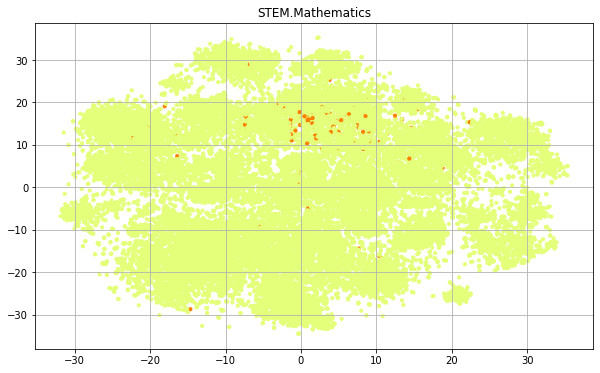

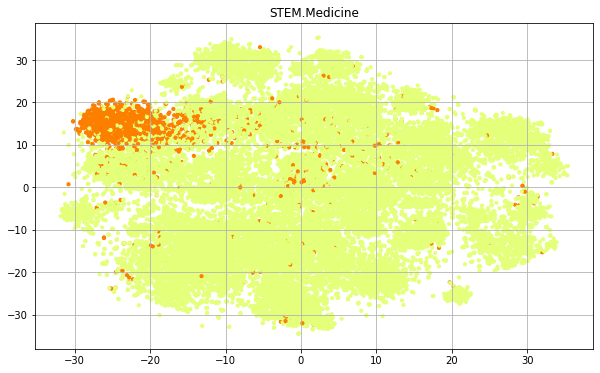

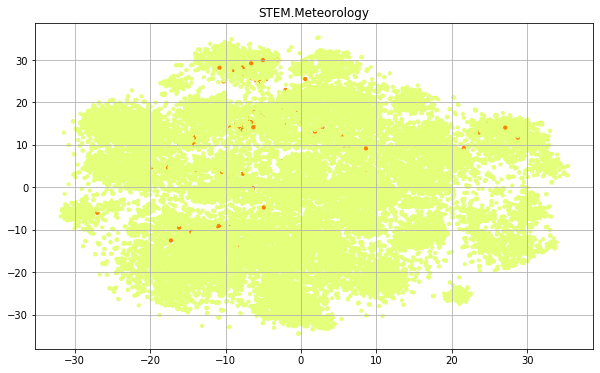

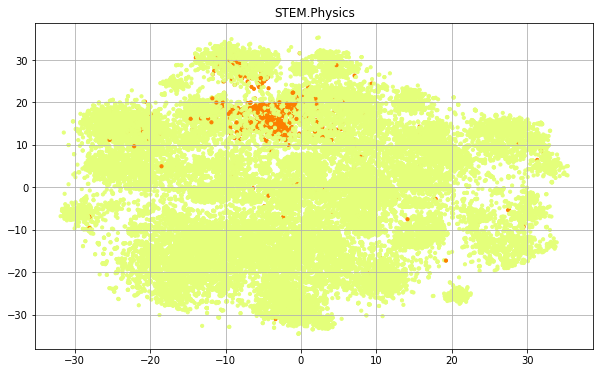

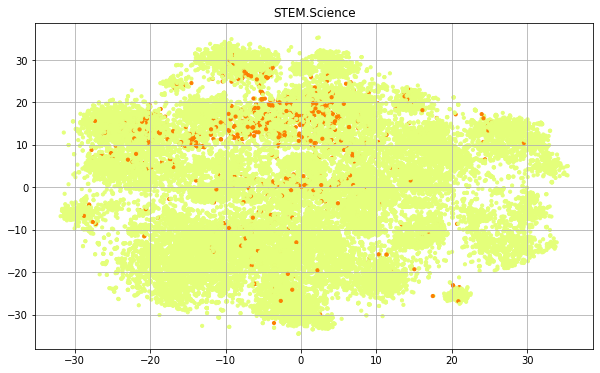

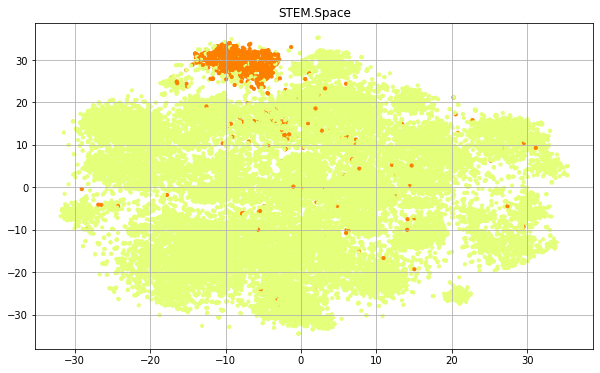

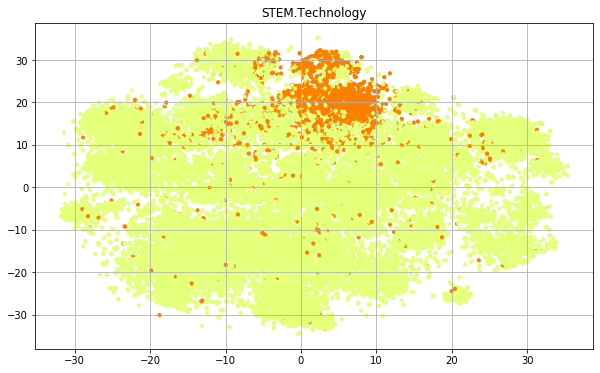

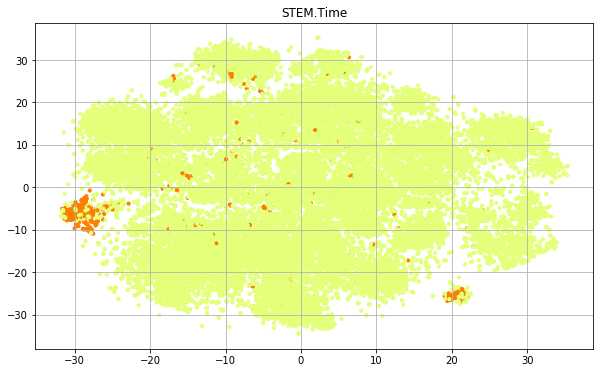

In [159]:
for label_id in range(45):
    plot_components(tsne_components, labels.cpu().detach().numpy(), label_id=label_id)

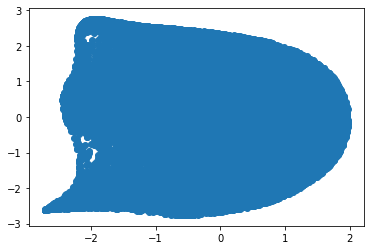

In [50]:
plt.scatter(tsne_components[:, 0], tsne_components[:, 1])

## Hyperparams

In [68]:
import torch
import pandas as pd

In [52]:
full_metrics_dict = torch.load("models/results_mean_v2.pth")

In [60]:
len(full_metrics_dict)

108

In [74]:
list_features = [
    ['_empty'],
    ['_topics'],
    ['_text_embed'],
    ['_topics', '_text_embed']
]
list_emb_dim = [100, 200, 300]
list_n_hidden = [50, 100, 150]
list_n_layers = [1, 2, 3]
list_aggregator = [
#     "mean",
#     "gcn", 
#     "pool",
    "lstm"
]

list_of_dict_rows = []
for idx, (features_names, embedding_dim, n_hidden, n_layers, aggregator_type)\
        in enumerate(product(list_features, list_emb_dim, list_n_hidden, list_n_layers, list_aggregator)):
    metrics = full_metrics_dict[idx]
    row = {
        "features_names": features_names,
        "embedding_dim": embedding_dim,
        "n_hidden": n_hidden,
        "n_layers": n_layers,
        "aggregator_type": aggregator_type,
        "f1_micro": metrics["val"]["best_f1_micro"],
    }
    list_of_dict_rows.append(row)

In [75]:
pd.DataFrame(list_of_dict_rows)

features_names  embedding_dim  n_hidden  n_layers  \
0                  [_empty]            100        50         1   
1                  [_empty]            100        50         2   
2                  [_empty]            100        50         3   
3                  [_empty]            100       100         1   
4                  [_empty]            100       100         2   
..                      ...            ...       ...       ...   
103  [_topics, _text_embed]            300       100         2   
104  [_topics, _text_embed]            300       100         3   
105  [_topics, _text_embed]            300       150         1   
106  [_topics, _text_embed]            300       150         2   
107  [_topics, _text_embed]            300       150         3   

    aggregator_type  f1_micro  
0              lstm     0.562  
1              lstm     0.578  
2              lstm     0.577  
3              lstm     0.587  
4              lstm     0.595  
..              ...       ...  
103            lstm     0.573  
104            lstm     0.584  
105            lstm     0.568  
106            lstm     0.583  
107            lstm     0.587  

[108 rows x 6 columns]